In [63]:
from importlib import reload
import numpy as np
import folium
import pandas as pd
import seaborn as sns
from random import sample
from sklearn.model_selection import train_test_split
import src.localization as localization
reload(localization)
from src.localization import read_data
from src.localization import plot_coeffs
from src.localization import get_distance_in_meters
from src.localization import gen_regressors
from src.localization import gen_fingerprints
from src.localization import cell_search
from src.localization import result_map
from src.localization import gen_taf_struct
from src.localization import search_taf
from src.localization import get_errors
from src.localization import show_stats
from src.localization import show_stats_graphs
from src.localization import show_box_plots
import matplotlib.pyplot as plt

1) Read Data
==
Read points and BTSs informations from CSV file

In [3]:
file = pd.read_csv('resources/data/data2.csv')
file

,pontoId,lat,lon,pathBTS1,pathBTS2,pathBTS3,pathBTS4,pathBTS5,pathBTS6,taBTS1,taBTS2,taBTS3,taBTS4,taBTS5,taBTS6
0,1,-8.077576,-34.899261,123.790000,88.956667,122.256667,126.890000,132.790000,138.056667,2,0,1,0,3,2
1,2,-8.077570,-34.899296,123.065000,104.540000,120.965000,137.140000,135.140000,139.015000,2,0,1,0,3,2
2,3,-8.077567,-34.899223,122.756667,88.723333,119.223333,124.256667,135.290000,132.923333,2,0,1,0,3,2
3,4,-8.077550,-34.899174,119.123333,82.056667,121.656667,126.856667,133.090000,133.923333,2,0,1,0,3,2
4,5,-8.077547,-34.899319,127.590000,110.890000,130.923333,138.290000,135.823333,135.123333,2,0,1,0,3,2
5,6,-8.077546,-34.899288,122.415000,91.190000,120.465000,128.165000,135.115000,134.040000,2,0,1,0,3,2
6,7,-8.077545,-34.899265,121.790000,89.240000,126.640000,127.340000,126.990000,140.140000,2,0,1,0,3,2
7,8,-8.077541,-34.899246,123.815000,87.890000,122.065000,126.740000,135.090000,138.590000,2,0,1,0,3,2
8,9,-8.077541,-34.899231,122.923333,84.523333,120.523333,125.856667,133.090000,135.990000,2,0,1,0,3,2
9,10,-8.077540,-34.899231,120.190000,81.890000,117.823333,124.290000,128.690000,137.956667,2,0,1,0,3,2


In [4]:
#positions, df_points_all = read_data('resources/data/LocTreino_Equipe_2.csv')
positions, df_points_all = read_data('resources/data/data2.csv')
df_points_test = pd.DataFrame()
all_indices = set(range(len(df_points_all)))
indices_test = sample(list(all_indices), int(len(df_points_all)/10))
indices_train = list(all_indices.difference(indices_test))
df_points = df_points_all.iloc[indices_train, :]
df_points_test = df_points_all.iloc[indices_test, :]

In [5]:
bts_positions, df_btss = read_data('resources/data/dados_BTSs.csv')

In [94]:
# import matplotlib.pyplot as plt

# # Time advance values above 7 are considered outliers
# ta_tresh = 7

# # print(df_points.columns[9:])
# # Remove all points with an outlier
# for column in df_points.columns[9:]:
#     print(df_points[df_points[column] >= ta_tresh][df_points.columns[9:]])
#     df_points = df_points[df_points[column] < ta_tresh]
# all_tas = list(df_points[df_points.columns[9:]].values.reshape((1,-1))[0])
# plt.plot(range(len(all_tas)), all_tas)
# plt.show()

## 1.1) Plot Original Points
Show the location of points and BTSs

In [6]:
# Calculate map center
center_lat = np.mean([lat for lat in bts_positions[:, 0]])
center_lon = np.mean([lon for lon in bts_positions[:, 1]])
original_pts_map = folium.Map(location=[center_lat, center_lon],
                              zoom_start=15,
                              tiles='CartoDB dark_matter')

In [7]:
# Plot points
for location in positions:
    marker = folium.CircleMarker(location=location,
                                 radius=1,
                                 color='blue',
                                 fill_opacity=0.1)
    marker.add_to(original_pts_map)

# Plot BTSs locations
for location in bts_positions:
    marker = folium.Marker(location=location)
    marker.add_to(original_pts_map)

# Export map
#original_pts_map.save("resources/maps/original_pts_map.html")

3) Fingerprint
==
Generate fingerprints for many cells to create a grid

## 3.1) Train Regressors
One regressor is trained for each BTS

In [8]:
# Path losses are the targets
# TODO: Replace path loss with output of propagation model
# Choose one of those?
# https://en.wikipedia.org/wiki/Radio_propagation_model
fingerprint_cols = ['pathBTS1',
                    'pathBTS2',
                    'pathBTS3',
                    'pathBTS4',
                    'pathBTS5',
                    'pathBTS6']
targets = [df_points[t_c] for t_c in fingerprint_cols]
#targets = [df_points_all[t_c] for t_c in fingerprint_cols]

# Input features
position_columns = ['lat', 'lon']
input_features = df_points[position_columns].values
#input_features = df_points_all[position_columns].values
regs = gen_regressors(input_features,
                      targets)

In [9]:
for reg in regs:
    print(reg)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=19, p=2,
          weights='uniform')
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=23, p=2,
          weights='uniform')
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=9, p=2,
          weights='uniform')
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=19, p=2,
          weights='uniform')
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=15, p=2,
          weights='uniform')


## 3.1) Generate Grid (with original positions and square grid cells)
A grid containing all the cells is generated. This is going to be consulted in the future

### 3.1.1) Add irregular cells
A cell is created for each point from the original training set

In [10]:
# Generate fingerprints for all samples
#fingerprints = gen_fingerprints(input_features,
#                                regs)
#fingerprints = list(fingerprints)
#cells = list(zip(list([list(x) for x in input_features]), fingerprints))

### 3.1.2) Add regular cells (this step may be skipped)
Additional cells are uniformly disposed in a rectagular grid

In [11]:
RESOLUTION = 20 #meters

print("SQUARE GRID GENERATOR")
print("\tResolution: {} m".format(RESOLUTION))



# Calculate limits
lats = np.array(list(df_points['lat']))
lons = np.array(list(df_points['lon']))
max_lat = lats.max()
min_lat = lats.min()
max_lon = lons.max()
min_lon = lons.min()

diff_lat = 0.0
diff_lon = 0.0
inc = 0.0000001
ref_lat = min_lat
ref_lon = min_lon
while(get_distance_in_meters(ref_lat, ref_lon, ref_lat+diff_lat, ref_lon) < RESOLUTION):
    diff_lat += inc
while(get_distance_in_meters(ref_lat, ref_lon, ref_lat, ref_lon+diff_lon) < RESOLUTION):
    diff_lon += inc

#while(get_distance_in_meters(max_lat, max_lon,min_lat,max_lon) < resolution)
#    diff_lat += inc

#vertical_distance = get_distance_in_meters(max_lat, max_lon,max_lat,min_lon)
#print(vertical_distance)
diff_lat

SQUARE GRID GENERATOR
	Resolution: 20 m


0.00017990000000000353

In [31]:
# Generate fingerprints for squared grid
cells = [] #added TO FIX
print(max_lat)
print(min_lat)

# Add grid points
number_of_squares = 200 #old value 20

#grid_lats = np.arange(min_lat, max_lat, diff_lat)

#grid_lons = np.arange(min_lon, max_lon, diff_lon)

grid_lats = np.linspace(min_lat,max_lat,number_of_squares)
grid_lons = np.linspace(min_lon,max_lon,number_of_squares)

lat_centers = [(l1 + l2)/2 for l1, l2 in zip(grid_lats, grid_lats[1:])]
lon_centers = [(l1 + l2)/2 for l1, l2 in zip(grid_lons, grid_lons[1:])]

samples = []
for lat in lat_centers:
    for lon in lon_centers:
        samples.append((lat, lon))
cells += list(zip(samples, gen_fingerprints(samples, regs)))
print(cells[0][0][0])
print(cells[0][0][1])
print(np.mean(cells[0][1]))
len(cells)

-8.059338
-8.07757
-8.077524190954772
-34.90677531909547
128.21685185185186


39601

## 3.2) Generate Grid Map

In [131]:
# Voronoi
from scipy.spatial import Voronoi
points = [(lat, lon) for (lat, lon), _ in cells]
vor = Voronoi(points)

# Create map
map_ = folium.Map(location=[center_lat, center_lon],
                 zoom_start=13,
                 tiles='CartoDB dark_matter')

# Add voronoi cells
for i1, i2 in vor.ridge_vertices:
    if i1 != -1 and i2 != -1:
        p1 = vor.vertices[i1]
        p2 = vor.vertices[i2]
        folium.PolyLine([p1, p2],
                        color='white',
                        weight=1,
                        opacity=0.2).add_to(map_)

# Add corners
corners = [[max_lat, max_lon],
           [max_lat, min_lon],
           [min_lat, max_lon],
           [min_lat, min_lon]]
for c in corners:
    marker = folium.Marker(location=c)
    marker.add_to(map_)

# Add grid points
for (lat, lon), _ in cells:
    marker = folium.CircleMarker(location=(lat,lon),
                                 color='blue',
                                 weight=2,
                                 radius=1,
                                 fill_color='blue',
                                 fill=True)
    marker.add_to(map_)
#map_.save("resources/maps/grid.html")

4) Search
==
Find the corresponding cell given a fingerprint

In [75]:
# Test with external data
equipe = 3
positions_test, df_points_test = read_data('resources/data/LocTreino_Equipe_{}.csv'.format(equipe))


## 4.1) Naive approach (sort)
For each test point, choose the cell with the closest (euclidean distance) fingerprint and save the result in a map.

In [24]:
pred_positions_naive = []
print(cells[0][0])
for point_tas, point_fp in zip(list(df_points_test.values[:, 9:]),
                               list(df_points_test.values[:, 3:9])):
    pos, _ = cell_search(point_fp, cells)
    pred_positions_naive.append(pos)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:
# Generate result map
result_map(list(df_points_test[position_columns].values),
           pred_positions_naive,
           "resources/maps/search_naive_result.html",
           only_show_error=False)

Map saved!


## 4.2) Using KNN classifier
For each test point, let the KNN classifier choose the cell

In [105]:
from sklearn.neighbors import KNeighborsClassifier

In [106]:
X_train = list([f for _, f in cells])
train_data_classes = range(len(X_train))
knn_squared_grid = KNeighborsClassifier(n_neighbors=1)
_ = knn_squared_grid.fit(X_train, train_data_classes)

In [108]:
# Test with external data
fingerprints = df_points_test[df_points_test.columns[3:9]].values
cells_idxs = knn_squared_grid.predict(fingerprints)
pred_positions_knn = [cells[i][0] for i in cells_idxs]

In [19]:
# Generate result map
result_map(list(df_points_test[position_columns].values),
           pred_positions_knn,
           "resources/maps/search_KNN_result.html",
           only_show_error=False)

Map saved!


## 4.2) Using TA Filter

In [13]:
btss = gen_taf_struct(df_btss, cells)
#btss

In [14]:
pred_positions_taf = []
reduced_sets = []
for point_tas, point_fp in zip(list(df_points_test.values[:, 9:]),
                               list(df_points_test.values[:, 3:9])):
    pos, reduced_set  = search_taf(point_tas, point_fp, btss)
    #print(pos)
    #print(reduced_set)
    pred_positions_taf.append(pos)
    reduced_sets.append(reduced_set)
print(np.mean(reduced_sets))
#reduced_sets

729.5728813559322


Generating Map Using Filtered By TA
==

In [23]:
# Generate result map
map_ = result_map(list(df_points_test[position_columns].values),
                  pred_positions_taf,
                  'resources/maps/search_taf_result.html',
                  only_show_error=False)

Map saved!


5) Statistics
==

In [15]:
#errors_naive = get_errors(df_points_test, pred_positions_naive)
#show_stats(errors_naive)
errors_taf = get_errors(df_points_test, pred_positions_taf)
show_stats(errors_taf)
#errors_knn = get_errors(df_points_test, pred_positions_knn)
#show_stats(errors_knn)

Min Error (in meters):0.889894423900525
Max Error (in meters):310.117205021187
Mean Error (in meters):67.25060804117558
Std. Deviation (in meters):59.27710055874579


## Testing All resolutions

Erro médio: para a resolução72.2212734605819 : 10
Erro médio: para a resolução71.55518464720966 : 15
Erro médio: para a resolução75.21178799788392 : 20
Erro médio: para a resolução79.67043082218504 : 50


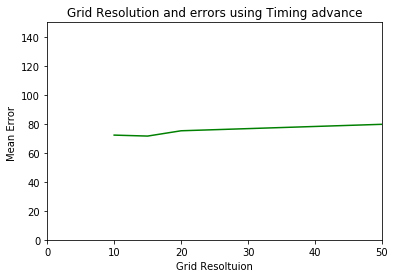

In [68]:
#tests = [10, 20, 50, 100, 200,300,400, 500, 600, 1000]
tests = [10, 15, 20, 50]
tests_errors = []

positions, df_points_all = read_data('resources/data/LocTreino_Equipe_2.csv')
bts_positions, df_btss = read_data('resources/data/dados_BTSs.csv')

for res in tests:
    RESOLUTION = res #meters
    errors = []

    for i in range(0, 10):
        #Load Test
        df_points_test = pd.DataFrame()
        all_indices = set(range(len(df_points_all)))
        indices_test = sample(list(all_indices), int(len(df_points_all)/10))
        indices_train = list(all_indices.difference(indices_test))
        df_points = df_points_all.iloc[indices_train, :]
        df_points_test = df_points_all.iloc[indices_test, :]

        #Train Regressores
        fingerprint_cols = ['pathBTS1',
                        'pathBTS2',
                        'pathBTS3',
                        'pathBTS4',
                        'pathBTS5',
                        'pathBTS6']
        targets = [df_points[t_c] for t_c in fingerprint_cols]
        #targets = [df_points_all[t_c] for t_c in fingerprint_cols]

        # Input features
        position_columns = ['lat', 'lon']
        input_features = df_points[position_columns].values
        #input_features = df_points_all[position_columns].values
        regs = gen_regressors(input_features,
                              targets)


        #print("SQUARE GRID GENERATOR")
        #print("\tResolution: {} m".format(RESOLUTION))

        # Calculate limits
        lats = np.array(list(df_points['lat']))
        lons = np.array(list(df_points['lon']))
        max_lat = lats.max()
        min_lat = lats.min()
        max_lon = lons.max()
        min_lon = lons.min()

        diff_lat = 0.0
        diff_lon = 0.0
        inc = 0.0000001
        ref_lat = min_lat
        ref_lon = min_lon
        while(get_distance_in_meters(ref_lat, ref_lon, ref_lat+diff_lat, ref_lon) < RESOLUTION):
            diff_lat += inc
        while(get_distance_in_meters(ref_lat, ref_lon, ref_lat, ref_lon+diff_lon) < RESOLUTION):
            diff_lon += inc
        cells = [] #added TO FIX
       # print(max_lat)
       # print(min_lat)

        # Add grid points
        number_of_squares = 1000 #old value 20

        grid_lats = np.arange(min_lat, max_lat, diff_lat)

        grid_lons = np.arange(min_lon, max_lon, diff_lon)

        #grid_lats = np.linspace(min_lat,max_lat,number_of_squares)
        #grid_lons = np.linspace(min_lon,max_lon,number_of_squares)

        lat_centers = [(l1 + l2)/2 for l1, l2 in zip(grid_lats, grid_lats[1:])]
        lon_centers = [(l1 + l2)/2 for l1, l2 in zip(grid_lons, grid_lons[1:])]

        samples = []
        for lat in lat_centers:
            for lon in lon_centers:
                samples.append((lat, lon))
        cells += list(zip(samples, gen_fingerprints(samples, regs)))
        len(cells)

        btss = gen_taf_struct(df_btss, cells)
        #print(btss)
        pred_positions_taf = []
        reduced_sets = []
        for point_tas, point_fp in zip(list(df_points_test.values[:, 9:]),
                                       list(df_points_test.values[:, 3:9])):
            pos, reduced_set  = search_taf(point_tas, point_fp, btss)
            #print(pos)
            #print(reduced_set)
            #pos_all = [a for a,b in reduced_set]
            
            #lat_pos_all = [lat for lat, lon in pos_all]
            #lon_pos_all = [lon for lat, lon in pos_all]
            
            #pondered_pos = (np.mean(lat_pos_all),np.mean(lon_pos_all))
            #print(pos)
            #print(pondered_pos)
            #print(lat_pos_all)
            pred_positions_taf.append(pos)
            reduced_sets.append(len(reduced_set))
        #print(np.mean(reduced_sets))
        errors_taf = get_errors(df_points_test, pred_positions_taf)
        errors.append(np.mean(errors_taf))
        #show_stats(errors_taf)
    error_res = np.mean(errors)
    tests_errors.append(error_res)
    print("Erro médio: para a resolução{0} : {1}".format(error_res, RESOLUTION))

    
plt.plot(tests, tests_errors, color='g')
plt.xlabel('Grid Resoltuion')
plt.ylabel('Mean Error ')
plt.title('Grid Resolution and errors using Timing advance')
plt.axis([0, 50,0, 150])
plt.show()

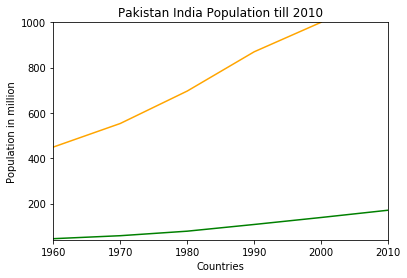

In [67]:
year = [1960, 1970, 1980, 1990, 2000, 2010]
pop_pakistan = [44.91, 58.09, 78.07, 107.7, 138.5, 170.6]
pop_india = [449.48, 553.57, 696.783, 870.133, 1000.4, 1309.1]
plt.plot(year, pop_pakistan, color='g')
plt.plot(year, pop_india, color='orange')
plt.xlabel('Countries')
plt.ylabel('Population in million')
plt.title('Pakistan India Population till 2010')
plt.axis([1960, 2010,40, 1000])
plt.show()

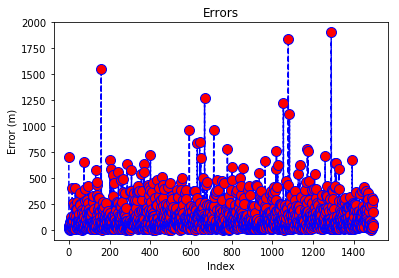

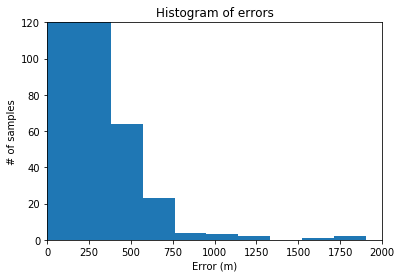

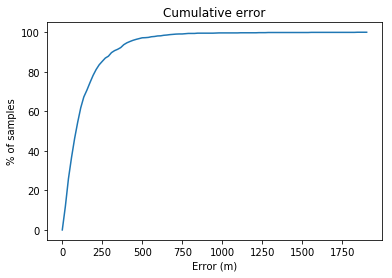

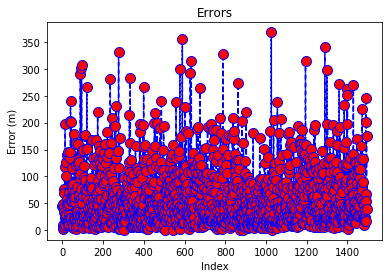

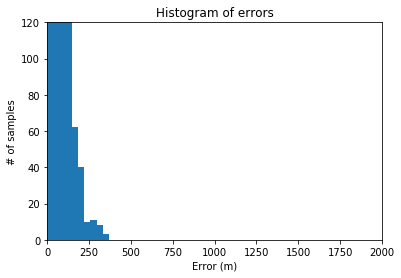

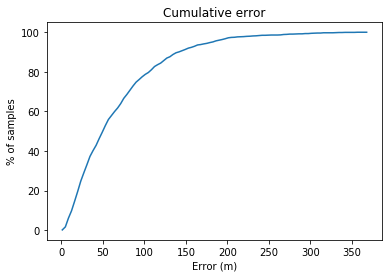

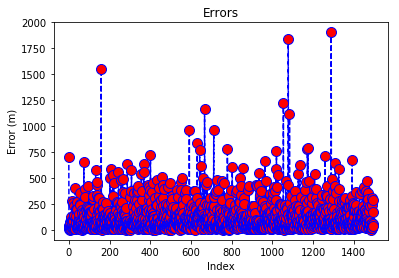

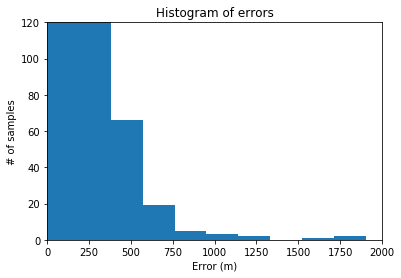

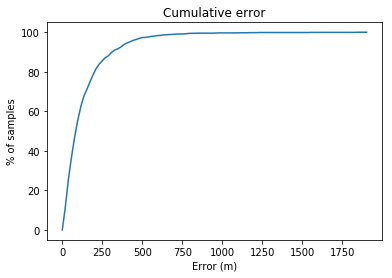

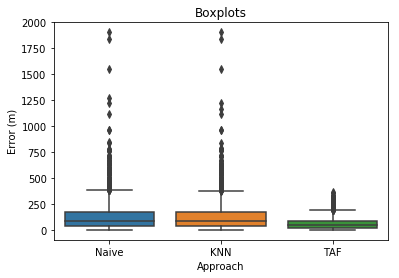

In [117]:
show_stats_graphs(errors_naive)
show_stats_graphs(errors_taf)
show_stats_graphs(errors_knn)
show_box_plots([errors_naive, errors_knn, errors_taf], ['Naive', 'KNN', 'TAF'])

In [17]:
cells = [ 1, 2, 3, 4]
np.mean(cells)

2.5

Análise de Dados
==

In [25]:
df_points_all.describe()

,pontoId,lat,lon,pathBTS1,pathBTS2,pathBTS3,pathBTS4,pathBTS5,pathBTS6,taBTS1,taBTS2,taBTS3,taBTS4,taBTS5,taBTS6
count,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000
mean,1506.504342,-8.069919,-34.894956,117.568644,118.876237,123.780815,116.064967,121.791164,125.109213,0.680027,1.079446,2.577297,1.042752,1.098864,1.036740
std,864.839304,0.004325,0.004359,20.507860,12.334898,9.223450,12.446132,12.360117,13.490190,0.706980,1.323937,1.424973,0.844637,0.848626,0.680604
min,2.000000,-8.077570,-34.906830,85.590000,76.423333,88.740000,83.640000,79.290000,87.823333,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,755.000000,-8.073171,-34.897587,106.990000,111.290000,119.190000,106.690000,114.490000,115.590000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000
50%,1492.000000,-8.069860,-34.895496,118.256667,120.140000,124.440000,116.523333,123.190000,128.223333,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000
75%,2274.000000,-8.066664,-34.891747,125.656667,128.156667,129.990000,126.056667,130.523333,135.723333,1.000000,1.000000,3.000000,1.000000,2.000000,2.000000
max,2956.000000,-8.059338,-34.885067,636.694439,144.890000,144.790000,145.023333,146.890000,150.123333,3.000000,35.327245,30.683919,4.000000,3.000000,2.000000


Saving Output Files
==

In [26]:
dic = {'pontoId':df_points_test['pontoId'],
       'lat':df_points_test['lat'],
       'lon':df_points_test['lon'],
       'lat_pred':[lat for lat, lon in pred_positions_taf],
       'lon_pred':[lon for lat, lon in pred_positions_taf],
       'erro_loc':errors_taf}
df_results = pd.DataFrame(dic,columns=dic.keys())
df_results.to_csv('resources/data/Resultados.csv')

In [ ]:
import scipy.stats as scp
error_1 = [27,2,4,18,7,9]
error_2 = [20, 8, 14, 36, 21,22]
error_3 = [34, 31,3,23, 30,6]

scp.stats.friedmanchisquare(errors_naive,
                            errors_knn,
                            errors_taf)